# MoveNet Doc

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [5]:
cd C:/Users/kcjer/OneDrive/바탕 화면/movenet

C:\Users\kcjer\OneDrive\바탕 화면\movenet


In [4]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}


In [56]:
def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.21):

    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)
        print(f"반복후보 1 {1}" ,end=" ")

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (kpts_scores[edge_pair[0]] > keypoint_threshold and
                kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                print(f"반복후보 2 {2}" ,end=" ")
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors



In [42]:
def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
    
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
             interpolation=cv2.INTER_CUBIC)
    return image_from_plot

In [43]:
model_name = "movenet_lightning_int8.tflite"

# Initialize the TFLite interpreter
input_size = 192
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

def movenet(input_image):
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores


In [59]:
# Load the input image.
image_path = r"C:\Users\kcjer\OneDrive\바탕 화면\img_model\studying_3\238_enhanced_1.28.jpg"
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

반복후보 1 1 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 반복후보 2 2 

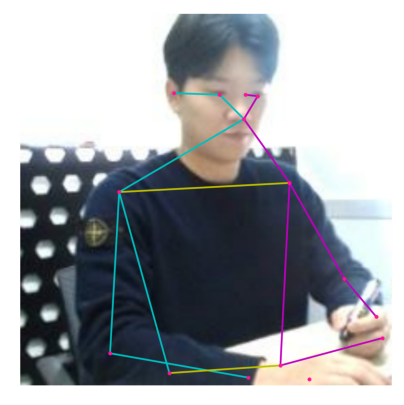

In [62]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')


# MoveNet test

In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [4]:
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_lightning_3.tflite")
interpreter.allocate_tensors()

## Draw Keypoints

In [5]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

## Draw Edges

In [6]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [7]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

## Make Detections

In [8]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3]),
  'shape_signature': array([  1, 192, 192,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [9]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3]),
  'shape_signature': array([ 1,  1, 17,  3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [12]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(f"벡터 :{keypoints_with_scores} \n\n\n")
    
#     # Rendering 
#     draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
#     draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    cv2.imshow('MoveNet Lightning', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

벡터 :[[[[0.6393311  0.4440421  0.6634991 ]
   [0.5888981  0.4819408  0.5162405 ]
   [0.5955167  0.4004413  0.6357628 ]
   [0.58882505 0.5254705  0.6046791 ]
   [0.59321594 0.3211454  0.6689636 ]
   [0.73474383 0.60401154 0.6859698 ]
   [0.7630948  0.21800011 0.7545178 ]
   [0.88809896 0.7389884  0.2873042 ]
   [0.96350753 0.099433   0.11978052]
   [0.971753   0.8678521  0.08325407]
   [0.9768028  0.2766075  0.0244855 ]
   [1.001276   0.5754957  0.08694089]
   [1.000751   0.32451192 0.04455133]
   [1.022151   0.689798   0.0086291 ]
   [0.8624379  0.12238146 0.02720264]
   [0.97538435 0.9107034  0.02829891]
   [0.8375136  0.10152432 0.0342755 ]]]] 



벡터 :[[[[0.63907033 0.44716948 0.6626221 ]
   [0.5874895  0.4856176  0.5736201 ]
   [0.59435946 0.4024439  0.69416404]
   [0.5865979  0.5279825  0.59854794]
   [0.5933597  0.32213914 0.67903453]
   [0.7323283  0.6070565  0.6725197 ]
   [0.7631092  0.21794188 0.72847223]
   [0.8877516  0.74072194 0.31289724]
   [0.9610843  0.09864523 0.1087485

벡터 :[[[[0.61923134 0.46261287 0.6539654 ]
   [0.5713104  0.4932719  0.41641322]
   [0.58365506 0.41700372 0.54053986]
   [0.57901704 0.5244924  0.40303895]
   [0.596434   0.33096755 0.6260109 ]
   [0.73176205 0.6031076  0.65902996]
   [0.7639889  0.21953723 0.756463  ]
   [0.8869661  0.74233127 0.34534317]
   [0.9618981  0.12491076 0.07564721]
   [0.97183746 0.87005323 0.08770596]
   [0.9796258  0.27549317 0.02263483]
   [1.0008721  0.57708156 0.08714207]
   [1.0019195  0.34129256 0.04477977]
   [0.89666504 0.7685509  0.02687371]
   [0.8620218  0.12349717 0.02895311]
   [0.9755527  0.90808535 0.03002553]
   [1.0093563  0.46218008 0.0092565 ]]]] 



벡터 :[[[[0.6183308  0.4595707  0.60304046]
   [0.572034   0.49023563 0.56368923]
   [0.583762   0.41294366 0.45051295]
   [0.5790152  0.5239664  0.41150782]
   [0.5962514  0.33060914 0.6346612 ]
   [0.73164123 0.60201985 0.6613087 ]
   [0.76215875 0.22029963 0.7662456 ]
   [0.88842523 0.74125695 0.33897203]
   [0.9631944  0.09870255 0.1180686

벡터 :[[[[0.64363056 0.4252673  0.60642517]
   [0.59245527 0.4667946  0.73192656]
   [0.5966759  0.38159022 0.7160616 ]
   [0.5904483  0.52091163 0.48389503]
   [0.5917553  0.31511152 0.5324651 ]
   [0.73378813 0.60689247 0.71809804]
   [0.7638826  0.21274102 0.7573669 ]
   [0.89533937 0.7502929  0.24677235]
   [0.961182   0.09862392 0.10169829]
   [0.973189   0.8820686  0.0991973 ]
   [0.981006   0.28297114 0.02124851]
   [1.0024204  0.5784613  0.07997431]
   [1.0035106  0.3109882  0.03695653]
   [1.0205815  0.69053626 0.00791739]
   [0.8571121  0.12462666 0.02037745]
   [0.9713081  0.8954797  0.02373935]
   [1.0144372  0.31305093 0.00615604]]]] 



벡터 :[[[[0.64455885 0.4244848  0.61226594]
   [0.5927343  0.4661119  0.74707186]
   [0.59725636 0.3806408  0.6998832 ]
   [0.59087515 0.5212921  0.49797577]
   [0.5927545  0.31522617 0.54822683]
   [0.7335781  0.6070094  0.7125828 ]
   [0.76493734 0.21374908 0.7427597 ]
   [0.8926519  0.75308263 0.24577837]
   [0.9593965  0.14651927 0.0487189

벡터 :[[[[0.6446215  0.4291811  0.57551277]
   [0.59297496 0.47096214 0.68127203]
   [0.5988933  0.38502032 0.7508055 ]
   [0.59253776 0.5240053  0.58953977]
   [0.59875154 0.31689334 0.60150456]
   [0.7346904  0.60654736 0.68434215]
   [0.76212466 0.21419792 0.7650082 ]
   [0.89239204 0.7459404  0.2354535 ]
   [0.96102345 0.09710696 0.09874999]
   [0.88984525 0.820028   0.05934667]
   [0.98194385 0.28333193 0.02131845]
   [0.99884    0.57688856 0.09547812]
   [1.0006514  0.32140237 0.04125307]
   [0.8879449  0.76923174 0.02810754]
   [0.85404265 0.12124454 0.02118039]
   [0.9750845  0.9103186  0.02518517]
   [1.0147231  0.31219944 0.00571584]]]] 



벡터 :[[[[0.64547515 0.4283919  0.5533369 ]
   [0.59446067 0.4698879  0.70595807]
   [0.60001135 0.38447982 0.7412451 ]
   [0.5940994  0.5238911  0.590765  ]
   [0.59953487 0.3171252  0.595537  ]
   [0.7349539  0.60776836 0.6909338 ]
   [0.7620981  0.21493773 0.76663464]
   [0.88899153 0.7409618  0.30323875]
   [0.9597535  0.14675295 0.0410011

벡터 :[[[[0.64581484 0.42907113 0.5489249 ]
   [0.5946195  0.47096357 0.66994774]
   [0.60004854 0.3854426  0.66367567]
   [0.5941974  0.5240839  0.61036015]
   [0.5978774  0.31654525 0.59813523]
   [0.735558   0.6086056  0.683964  ]
   [0.76154566 0.21350275 0.760197  ]
   [0.8939109  0.74673426 0.2405697 ]
   [0.95953244 0.14674768 0.04076258]
   [0.8899347  0.8145153  0.06453922]
   [0.98083186 0.2621578  0.02114142]
   [0.99688977 0.57558525 0.10477365]
   [0.9982339  0.3210624  0.04619668]
   [1.019184   0.6900031  0.00903863]
   [0.8546177  0.1220877  0.02366614]
   [0.88589764 0.82809067 0.01931755]
   [1.0130422  0.31294736 0.00603007]]]] 



벡터 :[[[[0.64399177 0.42876825 0.60302055]
   [0.59259045 0.47021842 0.6664823 ]
   [0.5981551  0.38514686 0.70405966]
   [0.5932003  0.5233121  0.5996849 ]
   [0.5973196  0.31605113 0.58965206]
   [0.73496747 0.607235   0.6800072 ]
   [0.7606799  0.2135611  0.7547239 ]
   [0.8905697  0.74072695 0.29780674]
   [0.95983356 0.14569603 0.0407217

벡터 :[[[[0.63983476 0.43069732 0.62777305]
   [0.5884852  0.4715141  0.62454236]
   [0.59493196 0.38648236 0.76785165]
   [0.5908031  0.522576   0.54789114]
   [0.59688103 0.31800535 0.6301652 ]
   [0.73288095 0.6063857  0.6843889 ]
   [0.76321316 0.21445996 0.7557613 ]
   [0.89674926 0.7457757  0.23384663]
   [0.9607419  0.09702422 0.09816141]
   [0.9730761  0.86834204 0.06148849]
   [0.9795377  0.2833302  0.02251167]
   [0.9996344  0.5790547  0.09048148]
   [0.9984538  0.3387961  0.04658126]
   [1.0204715  0.7094816  0.00792015]
   [0.85619587 0.12163477 0.02613444]
   [0.8497433  0.97438234 0.03116776]
   [1.0104811  0.3339703  0.00688876]]]] 



벡터 :[[[[0.6396437  0.43064004 0.6302563 ]
   [0.58807015 0.47177142 0.62407655]
   [0.59381485 0.3859901  0.7680262 ]
   [0.5909538  0.5225916  0.5620012 ]
   [0.59584343 0.31668758 0.6116232 ]
   [0.73147744 0.6072062  0.694064  ]
   [0.7632021  0.21401793 0.76130545]
   [0.8990176  0.74748266 0.24975185]
   [0.9604365  0.09790996 0.1014044

벡터 :[[[[0.6448143  0.42728847 0.58488476]
   [0.59517616 0.46746916 0.6791371 ]
   [0.60103667 0.383407   0.7597532 ]
   [0.59923124 0.5223491  0.5805931 ]
   [0.60711795 0.31558216 0.50538504]
   [0.7324922  0.6153271  0.60101193]
   [0.76157206 0.20984244 0.7243868 ]
   [0.88463223 0.71756357 0.20840748]
   [0.9617369  0.09674182 0.10848214]
   [0.87460065 0.7251446  0.08106266]
   [0.8825369  0.21402618 0.01409686]
   [0.9899181  0.5746598  0.12358836]
   [0.99305904 0.32121733 0.05946908]
   [0.8664631  0.70755976 0.03691047]
   [0.85484135 0.11618315 0.03126997]
   [0.86155796 0.7338108  0.03421394]
   [0.8373148  0.10335426 0.03340527]]]] 



벡터 :[[[[0.644162   0.42924327 0.56636286]
   [0.59539884 0.47142416 0.66139066]
   [0.6011872  0.3865782  0.7241051 ]
   [0.60253996 0.5241729  0.47410256]
   [0.605052   0.3179732  0.48827904]
   [0.73699033 0.60659385 0.58248407]
   [0.7596807  0.2108963  0.7359033 ]
   [0.8858268  0.7111964  0.2144424 ]
   [0.96186316 0.09641671 0.1086710

벡터 :[[[[0.6405729  0.42368206 0.7219042 ]
   [0.5875896  0.4652213  0.6504158 ]
   [0.5941793  0.37899825 0.5251723 ]
   [0.58541226 0.5208322  0.41458213]
   [0.5899777  0.31203663 0.46903998]
   [0.73198783 0.61003184 0.47011745]
   [0.75976026 0.21099333 0.57818073]
   [0.89273965 0.7402986  0.18867983]
   [0.9549186  0.11489594 0.06653135]
   [0.9017379  0.8510723  0.0642628 ]
   [0.98098826 0.26397604 0.01974017]
   [1.0009881  0.5758412  0.08463938]
   [0.9998035  0.34095058 0.04213974]
   [1.019628   0.6877929  0.00897902]
   [0.8441422  0.1091589  0.03211436]
   [0.9718554  0.9141676  0.02767949]
   [0.74504155 0.0198628  0.03346835]]]] 



벡터 :[[[[0.6406874  0.42183894 0.6895553 ]
   [0.5875273  0.46279806 0.6508847 ]
   [0.59391624 0.37655938 0.51698923]
   [0.5870173  0.51769674 0.38290614]
   [0.592958   0.30949694 0.5625205 ]
   [0.7288766  0.6108285  0.6470802 ]
   [0.7563831  0.20363396 0.55680287]
   [0.8953396  0.7284298  0.18727875]
   [0.87292206 0.08030646 0.1016938

벡터 :[[[[0.6465427  0.4176628  0.36390236]
   [0.5945059  0.458858   0.57456875]
   [0.5984051  0.37470925 0.44055536]
   [0.59135693 0.51442915 0.38757133]
   [0.5936131  0.3127094  0.52089125]
   [0.72970235 0.604157   0.6652262 ]
   [0.7577945  0.20925245 0.732469  ]
   [0.88746524 0.7211368  0.22761138]
   [0.9608345  0.09373304 0.08583613]
   [0.9037367  0.8528101  0.0534404 ]
   [0.9849733  0.26040882 0.01831837]
   [1.0046781  0.57191443 0.06739259]
   [1.0068103  0.2945315  0.02581929]
   [1.023511   0.66651607 0.00957388]
   [0.85185647 0.12194028 0.01432444]
   [0.97272176 0.91655266 0.02568963]
   [1.0247049  0.29052395 0.00446223]]]] 



벡터 :[[[[0.64554864 0.41921616 0.5403757 ]
   [0.59310067 0.45996758 0.57660556]
   [0.5980119  0.3749337  0.45428953]
   [0.5899532  0.5156716  0.3850146 ]
   [0.5931693  0.31208658 0.5479423 ]
   [0.73168397 0.6064996  0.6987184 ]
   [0.76003313 0.20917748 0.74666464]
   [0.895103   0.74327797 0.2236596 ]
   [0.9617735  0.09523844 0.090601 

벡터 :[[[[0.6417823  0.42116553 0.60089207]
   [0.59092337 0.46277222 0.64960974]
   [0.59347403 0.37810144 0.54465747]
   [0.58898664 0.5181007  0.44460085]
   [0.5874082  0.3160932  0.5150954 ]
   [0.7307295  0.6068872  0.71060926]
   [0.75846165 0.22537431 0.60520935]
   [0.8896224  0.73817796 0.14846   ]
   [0.96233606 0.12087037 0.06856412]
   [0.9424542  0.87558305 0.07067298]
   [0.98058784 0.30984396 0.01786833]
   [1.0059631  0.5747258  0.06634136]
   [1.0056438  0.34231168 0.03185965]
   [1.021133   0.6465769  0.00765422]
   [0.79292125 0.18859372 0.01642129]
   [0.9755447  0.9118611  0.02536676]
   [1.0260181  0.27485576 0.00364956]]]] 



벡터 :[[[[0.6423974  0.42208803 0.6104815 ]
   [0.59257454 0.46371564 0.6920616 ]
   [0.5945737  0.3796684  0.61415815]
   [0.59008366 0.51898915 0.49447125]
   [0.5873426  0.31868792 0.5316309 ]
   [0.7307736  0.6051645  0.7057849 ]
   [0.7586235  0.22575405 0.59663725]
   [0.8891132  0.7216462  0.24109943]
   [0.96166897 0.12071498 0.0744426

벡터 :[[[[0.6256944  0.40831804 0.54995275]
   [0.579877   0.44935244 0.7028135 ]
   [0.57801497 0.36821085 0.7509004 ]
   [0.5878532  0.5114418  0.52869105]
   [0.5799506  0.31389552 0.53498   ]
   [0.72472084 0.60423976 0.6160641 ]
   [0.7562957  0.20968758 0.7221316 ]
   [0.88689727 0.73588395 0.18502958]
   [0.9621215  0.08100147 0.10727133]
   [0.8767211  0.7422096  0.02897148]
   [0.983158   0.26113814 0.02011938]
   [0.9978852  0.5605139  0.09997726]
   [0.99872184 0.33849365 0.04712034]
   [1.0134851  0.6242955  0.01312995]
   [0.8513388  0.11640533 0.02445054]
   [1.0067536  0.58682513 0.00523045]
   [0.8372054  0.10445138 0.02948793]]]] 



벡터 :[[[[0.6240958  0.40926406 0.5724875 ]
   [0.5776701  0.45033976 0.727167  ]
   [0.57655406 0.36912608 0.70761514]
   [0.58716893 0.5116186  0.5114193 ]
   [0.57951486 0.31433576 0.5358778 ]
   [0.72512853 0.6036476  0.6308278 ]
   [0.7614462  0.21326546 0.52777016]
   [0.8877341  0.7228943  0.24891716]
   [0.96270794 0.08242507 0.1087136

벡터 :[[[[0.62919044 0.4096919  0.5679219 ]
   [0.5839476  0.452803   0.5669403 ]
   [0.58046925 0.3692884  0.6142436 ]
   [0.5887214  0.5133314  0.56724155]
   [0.5833811  0.3129657  0.42452395]
   [0.7260646  0.604861   0.6288364 ]
   [0.75651187 0.20941487 0.71321285]
   [0.8885188  0.73678255 0.13617566]
   [0.9621912  0.08196405 0.111114  ]
   [0.8760993  0.74253154 0.02578273]
   [0.9806742  0.25965017 0.02276346]
   [0.9988868  0.5601771  0.09556247]
   [1.0003492  0.30905014 0.04214178]
   [1.0123913  0.64533377 0.01327415]
   [0.8513886  0.11708089 0.02366788]
   [1.0080338  0.58626103 0.00494466]
   [0.84019345 0.10360196 0.0277284 ]]]] 



벡터 :[[[[0.6288985  0.41238627 0.5046969 ]
   [0.58132845 0.455314   0.41309056]
   [0.5791311  0.3711955  0.5536207 ]
   [0.58886313 0.5138898  0.57140625]
   [0.58244526 0.31345016 0.42376322]
   [0.7272198  0.6059756  0.6390735 ]
   [0.75973654 0.21060584 0.5759294 ]
   [0.89249945 0.74401665 0.20473257]
   [0.9623058  0.08369934 0.1064107

벡터 :[[[[0.6263833  0.4080132  0.48600987]
   [0.57877237 0.44897127 0.66347396]
   [0.5774102  0.3670995  0.74575317]
   [0.5873147  0.5106832  0.5628066 ]
   [0.58218044 0.31078136 0.39023313]
   [0.7269087  0.60448563 0.65983796]
   [0.75544655 0.2128104  0.70061433]
   [0.89000577 0.7392795  0.15111907]
   [0.9633407  0.10153546 0.07750984]
   [0.8916637  0.8206798  0.05885695]
   [0.9794884  0.26446956 0.01672978]
   [1.0027478  0.57404137 0.07879811]
   [1.0015206  0.3574265  0.0369099 ]
   [1.0135632  0.62695956 0.0088225 ]
   [0.7995814  0.1733953  0.01576955]
   [1.0099862  0.5534576  0.00297152]
   [0.8405472  0.12883615 0.01184557]]]] 



벡터 :[[[[0.62213033 0.4081897  0.6588502 ]
   [0.5755391  0.4490767  0.6846696 ]
   [0.57558084 0.3678306  0.73139584]
   [0.5862472  0.5100972  0.54319185]
   [0.5845554  0.31236833 0.49850097]
   [0.728078   0.6053621  0.6526209 ]
   [0.7543777  0.21117806 0.7751329 ]
   [0.9093172  0.73991215 0.10797262]
   [0.9635078  0.10273602 0.0785221

벡터 :[[[[0.6432655  0.4115308  0.5787693 ]
   [0.5930072  0.45330387 0.4493541 ]
   [0.59537244 0.3693746  0.7144458 ]
   [0.59327817 0.512295   0.61442226]
   [0.5915975  0.31200498 0.53973496]
   [0.73101634 0.6044535  0.6955987 ]
   [0.763457   0.20535332 0.6465485 ]
   [0.8950002  0.7440821  0.2315462 ]
   [0.961998   0.08260928 0.12175379]
   [0.9032452  0.847571   0.05731525]
   [0.98580205 0.22056532 0.02184202]
   [1.0081356  0.5753562  0.05591772]
   [1.0095229  0.2956977  0.02465554]
   [1.0225526  0.6670477  0.00823012]
   [0.8549148  0.12019475 0.01960431]
   [0.9752404  0.9146437  0.02059105]
   [0.8406074  0.10247791 0.01718936]]]] 



벡터 :[[[[0.6440713  0.4065306  0.6131839 ]
   [0.5939628  0.44855544 0.69153893]
   [0.5951469  0.3641479  0.8191817 ]
   [0.5943844  0.50879484 0.650754  ]
   [0.5911804  0.30891103 0.56917465]
   [0.73019904 0.6038642  0.6908003 ]
   [0.7667522  0.20240352 0.7373959 ]
   [0.8944146  0.7416978  0.21719499]
   [0.96147215 0.08223265 0.1078249

벡터 :[[[[0.64073884 0.41575164 0.5395651 ]
   [0.5897702  0.4566422  0.54366076]
   [0.5912732  0.37305033 0.54286015]
   [0.5903039  0.51253945 0.5843657 ]
   [0.58957464 0.31127924 0.52008915]
   [0.7334324  0.6041108  0.71500206]
   [0.7612519  0.20573197 0.7641115 ]
   [0.9295602  0.7332444  0.0860227 ]
   [0.96202266 0.09773061 0.08690596]
   [0.90208435 0.8531035  0.06614041]
   [0.9835851  0.2410435  0.01864008]
   [1.0050356  0.57527804 0.06811389]
   [1.005218   0.33965278 0.02827539]
   [1.0198859  0.6675168  0.00860252]
   [0.85633767 0.12852407 0.01471865]
   [0.9722222  0.91279876 0.02216653]
   [1.0256094  0.29360026 0.0045149 ]]]] 



벡터 :[[[[0.6380262  0.41668567 0.5388851 ]
   [0.5878227  0.457249   0.5360327 ]
   [0.5899734  0.37362713 0.47132188]
   [0.5894697  0.5126723  0.57434154]
   [0.58771515 0.31117585 0.44681594]
   [0.7331983  0.602998   0.7067901 ]
   [0.75863564 0.2068138  0.7268425 ]
   [0.9213927  0.7251014  0.11690935]
   [0.96237105 0.0958122  0.0801381

벡터 :[[[[0.6293302  0.43030095 0.5353136 ]
   [0.58023536 0.47062165 0.7177545 ]
   [0.5834233  0.3856531  0.5364593 ]
   [0.58752954 0.5146774  0.34926724]
   [0.59387994 0.31490555 0.6071626 ]
   [0.73027265 0.60416764 0.6732138 ]
   [0.7631924  0.20941135 0.6679716 ]
   [0.886914   0.72137666 0.26071155]
   [0.96007264 0.09733277 0.09807462]
   [0.9008342  0.85253394 0.08602098]
   [0.98638123 0.26311994 0.0208657 ]
   [1.0002911  0.5724268  0.08742774]
   [0.9983002  0.33857876 0.0416654 ]
   [0.8859993  0.74142116 0.02186912]
   [0.86153436 0.23956572 0.00830738]
   [0.8978294  0.87113446 0.02343268]
   [1.0197893  0.3338544  0.00685782]]]] 



벡터 :[[[[0.6322121  0.42677817 0.6502358 ]
   [0.58259606 0.46619254 0.6413907 ]
   [0.58632183 0.38211447 0.5261363 ]
   [0.5862238  0.51203936 0.5347693 ]
   [0.5947828  0.31225425 0.5674804 ]
   [0.73104644 0.6037618  0.67322093]
   [0.76533955 0.20924966 0.65081227]
   [0.92765677 0.7362772  0.07659449]
   [0.95965064 0.14707696 0.0417997

벡터 :[[[[0.640195   0.39851314 0.6185998 ]
   [0.5887442  0.44110775 0.62635946]
   [0.591864   0.35411045 0.48518243]
   [0.5867238  0.5024011  0.49754387]
   [0.5873018  0.30220178 0.608742  ]
   [0.72962666 0.6000239  0.64841115]
   [0.7668438  0.20315468 0.7290375 ]
   [0.8884748  0.73440313 0.1546065 ]
   [0.9607854  0.08381847 0.1120297 ]
   [0.9012901  0.85298455 0.07083586]
   [0.9807755  0.24455297 0.02421709]
   [1.0076854  0.5729331  0.05616444]
   [1.0063066  0.27970815 0.03119973]
   [0.88458866 0.76479405 0.02408806]
   [0.85158134 0.12452673 0.01656663]
   [0.8978616  0.8740873  0.02088258]
   [1.01794    0.21223377 0.00474656]]]] 



벡터 :[[[[0.6402965  0.39842278 0.6204949 ]
   [0.58836734 0.44134504 0.62155294]
   [0.59188914 0.3535548  0.46212378]
   [0.5868094  0.50184643 0.48432156]
   [0.58761895 0.30183762 0.61730146]
   [0.7307682  0.5994649  0.6517425 ]
   [0.76552606 0.20323676 0.7367004 ]
   [0.8963584  0.7265073  0.14229308]
   [0.9614744  0.08416819 0.1167541

벡터 :[[[[0.6381638  0.39781064 0.5981047 ]
   [0.58746123 0.44084287 0.60502183]
   [0.5890826  0.35367236 0.49205002]
   [0.5867294  0.50300074 0.48232263]
   [0.58170843 0.30319628 0.6555276 ]
   [0.7302787  0.600204   0.662832  ]
   [0.7645154  0.20133637 0.7786966 ]
   [0.89397424 0.7350692  0.11745576]
   [0.96424645 0.08564123 0.11855463]
   [0.87884945 0.75941074 0.03025347]
   [0.9786421  0.23638019 0.02676138]
   [1.0085607  0.5719439  0.05369146]
   [1.0100538  0.26803443 0.02849039]
   [1.0219417  0.62427443 0.00730698]
   [0.85187316 0.12519486 0.01596117]
   [0.97337675 0.89632916 0.01930712]
   [1.0139207  0.20570187 0.00502163]]]] 



벡터 :[[[[0.63731664 0.39642772 0.5473136 ]
   [0.585561   0.43991905 0.56346524]
   [0.58788884 0.35182053 0.38888812]
   [0.58269256 0.50187325 0.46327314]
   [0.5794813  0.30209026 0.69158024]
   [0.7289428  0.59983844 0.6535305 ]
   [0.76184165 0.20100668 0.8120784 ]
   [0.8979861  0.7242485  0.16250336]
   [0.9631572  0.09623612 0.0895569

벡터 :[[[[0.6375209  0.39933282 0.6208687 ]
   [0.58666    0.4416951  0.61719185]
   [0.5879407  0.35560054 0.5397531 ]
   [0.58676004 0.5032202  0.5153243 ]
   [0.5807818  0.30465472 0.65655136]
   [0.7306449  0.6007759  0.6565797 ]
   [0.7666437  0.20077401 0.74677753]
   [0.8970179  0.72736925 0.1572331 ]
   [0.96126884 0.08357134 0.11495719]
   [0.87746406 0.7393088  0.02773501]
   [0.98343444 0.24081814 0.02476473]
   [1.0066133  0.5719037  0.05705266]
   [1.0107298  0.2818471  0.02475967]
   [1.0145844  0.62575746 0.00914413]
   [0.85283494 0.12218907 0.01674565]
   [1.0146477  0.5686201  0.00384945]
   [1.0197155  0.20915651 0.00431819]]]] 



벡터 :[[[[0.6428044  0.40035376 0.5822278 ]
   [0.5910264  0.4425156  0.650569  ]
   [0.59320515 0.35578376 0.5791949 ]
   [0.5891758  0.50202364 0.5132086 ]
   [0.58754385 0.3010031  0.6109451 ]
   [0.72912854 0.597813   0.61625314]
   [0.7663108  0.2022162  0.73115575]
   [0.8917854  0.7244295  0.1675483 ]
   [0.9608943  0.08402046 0.1134099

벡터 :[[[[0.63439286 0.40703362 0.7034416 ]
   [0.585033   0.4463374  0.55284286]
   [0.5852     0.3631483  0.61339223]
   [0.58683336 0.5024881  0.4703191 ]
   [0.5864902  0.30314064 0.58089375]
   [0.731769   0.5997021  0.66659296]
   [0.76323295 0.20261578 0.7448081 ]
   [0.88986456 0.7309439  0.15341264]
   [0.9602686  0.09928634 0.09711865]
   [0.87929296 0.76022303 0.03306852]
   [0.9831466  0.24194288 0.02507242]
   [1.003011   0.57184803 0.07017095]
   [1.0048966  0.33877394 0.02967055]
   [1.0169778  0.6270139  0.00814492]
   [0.85280746 0.12370038 0.01817419]
   [1.0164248  0.6047851  0.00445695]
   [1.0181689  0.24928892 0.00528453]]]] 



벡터 :[[[[0.63611895 0.40779135 0.6937717 ]
   [0.5863038  0.4466911  0.57822585]
   [0.5866136  0.36430317 0.6605195 ]
   [0.5872922  0.5017979  0.46205616]
   [0.58714914 0.30323103 0.5976498 ]
   [0.72974205 0.59974694 0.6368053 ]
   [0.7645137  0.20030764 0.7578185 ]
   [0.8892391  0.72903764 0.15716039]
   [0.960303   0.09948643 0.0970291

벡터 :[[[[0.6379638  0.40760574 0.689402  ]
   [0.58770514 0.44715327 0.58315474]
   [0.59089494 0.36356938 0.7608792 ]
   [0.5877603  0.5042478  0.49597472]
   [0.5904347  0.30433545 0.65714014]
   [0.73124355 0.6017471  0.6750377 ]
   [0.76348674 0.19930151 0.77010024]
   [0.89155126 0.73060846 0.13870077]
   [0.9608852  0.09738895 0.08927852]
   [0.8800585  0.7606501  0.03643452]
   [0.9842485  0.24203858 0.02372652]
   [1.0045952  0.573485   0.06649268]
   [1.0045034  0.33854872 0.02981277]
   [1.0221995  0.6475138  0.00723825]
   [0.8478595  0.12396106 0.01869739]
   [1.0227232  0.626893   0.0037878 ]
   [1.0186212  0.26999047 0.00569736]]]] 



벡터 :[[[[0.6380133  0.40864646 0.70067394]
   [0.5883017  0.44644052 0.59411025]
   [0.5908556  0.36426318 0.73555946]
   [0.5881117  0.5027742  0.48190665]
   [0.591431   0.3027229  0.70177937]
   [0.73015285 0.6022506  0.6723075 ]
   [0.76284766 0.19684032 0.7817607 ]
   [0.89310426 0.72381616 0.16496661]
   [0.9611065  0.09990118 0.0933346

벡터 :[[[[0.64223015 0.41355497 0.5833477 ]
   [0.5917245  0.45180878 0.52290714]
   [0.59718615 0.36910126 0.66379887]
   [0.589089   0.50334704 0.5679717 ]
   [0.59588933 0.304889   0.7572902 ]
   [0.73189723 0.59770393 0.6285231 ]
   [0.7662861  0.20500563 0.70812565]
   [0.8912926  0.7259614  0.1411093 ]
   [0.9604702  0.09944609 0.09568825]
   [0.87601256 0.7436178  0.02800676]
   [0.98483366 0.26047322 0.02311467]
   [1.002645   0.5729046  0.07374243]
   [1.0027372  0.3383455  0.03332955]
   [1.0207381  0.6685214  0.00831598]
   [0.8504872  0.12567036 0.01826733]
   [1.0272439  0.6682078  0.00349539]
   [1.0194368  0.29058266 0.00585395]]]] 



벡터 :[[[[0.64148384 0.41482827 0.504585  ]
   [0.5894986  0.4534572  0.3797947 ]
   [0.5964619  0.36962578 0.63925993]
   [0.5891416  0.50450677 0.57710433]
   [0.5956669  0.3050441  0.7612714 ]
   [0.73309106 0.5997816  0.6459949 ]
   [0.7669655  0.20414305 0.6915342 ]
   [0.89395535 0.7254983  0.13805673]
   [0.9602298  0.09830789 0.0918770

벡터 :[[[[0.6394063  0.41463313 0.535734  ]
   [0.5896522  0.4521984  0.5489737 ]
   [0.5939653  0.370744   0.6428555 ]
   [0.5882301  0.5029015  0.52261347]
   [0.5938702  0.30563974 0.73296475]
   [0.7321657  0.59912443 0.64691955]
   [0.7652329  0.20213644 0.7396011 ]
   [0.8882377  0.72981685 0.15007044]
   [0.96025956 0.0998643  0.09605391]
   [0.876892   0.7425835  0.02876201]
   [0.9839387  0.2599735  0.02348702]
   [1.0054247  0.57317805 0.064725  ]
   [1.0037763  0.33764908 0.03065215]
   [1.0235856  0.6682071  0.0080808 ]
   [0.8634254  0.19468379 0.0056115 ]
   [1.0275528  0.6676512  0.00344445]
   [1.0185837  0.28922775 0.00571785]]]] 



벡터 :[[[[0.64160454 0.4116549  0.59573424]
   [0.5905291  0.4494697  0.62112033]
   [0.59622854 0.3674124  0.72795653]
   [0.58942807 0.5025829  0.51201093]
   [0.5954604  0.30458587 0.7567235 ]
   [0.7311536  0.5998523  0.65565366]
   [0.76439583 0.2024648  0.7470213 ]
   [0.8887938  0.7253244  0.15330437]
   [0.96080184 0.09801617 0.0977582

벡터 :[[[[0.6408546  0.40680453 0.63495636]
   [0.5918995  0.4449224  0.66173184]
   [0.59612024 0.36334714 0.7859124 ]
   [0.5908923  0.5022615  0.5098013 ]
   [0.59487844 0.3036488  0.74484456]
   [0.7309925  0.6001701  0.6615946 ]
   [0.76452535 0.20201825 0.75650007]
   [0.8901895  0.7257351  0.14334984]
   [0.9597313  0.09777403 0.08959735]
   [0.8765995  0.74235725 0.02564509]
   [0.9836442  0.2602879  0.02467072]
   [1.0065712  0.57147753 0.0608575 ]
   [1.0090679  0.3108276  0.02649806]
   [1.0250725  0.64678514 0.00687031]
   [0.8496334  0.12525639 0.01751953]
   [0.9997691  0.8883011  0.01909532]
   [1.0183805  0.27029204 0.00550415]]]] 



벡터 :[[[[0.641222   0.40745962 0.62365687]
   [0.5916147  0.4456218  0.65431064]
   [0.5964762  0.36349115 0.7932761 ]
   [0.59003747 0.5019211  0.5047109 ]
   [0.5949272  0.30348468 0.74490297]
   [0.73124117 0.5981933  0.6475309 ]
   [0.76472056 0.20422219 0.73286045]
   [0.89091253 0.72841066 0.14527386]
   [0.96028274 0.09784366 0.0969313

벡터 :[[[[0.6468327  0.40555483 0.56084526]
   [0.5943083  0.4447429  0.709978  ]
   [0.5996464  0.36102718 0.7461406 ]
   [0.59057134 0.5026847  0.50925314]
   [0.5968921  0.30239558 0.7545871 ]
   [0.72989243 0.59667134 0.59521234]
   [0.767024   0.20565423 0.6650149 ]
   [0.89050496 0.72982043 0.19239256]
   [0.96251386 0.12928224 0.05940688]
   [0.97174025 0.8660633  0.06593119]
   [0.97780895 0.23834759 0.02960477]
   [1.006397   0.57381463 0.06084676]
   [1.006908   0.29332352 0.03061933]
   [1.0226789  0.668802   0.00757422]
   [0.86236966 0.11167379 0.01737198]
   [0.974      0.8930273  0.01980716]
   [1.0106239  0.2658942  0.00628771]]]] 



벡터 :[[[[0.6461078  0.40585172 0.5722009 ]
   [0.59392774 0.44481468 0.72767484]
   [0.5993465  0.36091822 0.74230397]
   [0.59032214 0.502594   0.5024146 ]
   [0.5969721  0.30281746 0.75590736]
   [0.72848856 0.5951595  0.56068075]
   [0.7662643  0.20491718 0.6642301 ]
   [0.8875543  0.71955466 0.21935809]
   [0.96161807 0.12951711 0.0606297

벡터 :[[[[0.64897025 0.4044417  0.4610588 ]
   [0.5952441  0.4433111  0.6918398 ]
   [0.5978648  0.35741374 0.6103699 ]
   [0.59107554 0.50246716 0.5196754 ]
   [0.59209263 0.30039325 0.6907228 ]
   [0.72825927 0.5965516  0.5957607 ]
   [0.76418376 0.20007841 0.7607173 ]
   [0.88423216 0.7311947  0.15044166]
   [0.9612094  0.08461428 0.11518463]
   [0.87631285 0.7432041  0.02512892]
   [0.9806918  0.23997301 0.02675496]
   [1.0061169  0.57090837 0.05986791]
   [1.0085872  0.2798632  0.0274036 ]
   [1.0254532  0.6258378  0.00656493]
   [0.8521689  0.12221732 0.01418287]
   [1.0188414  0.60161304 0.00396828]
   [1.0148417  0.2473692  0.00532688]]]] 



벡터 :[[[[0.6487103  0.40444764 0.45971298]
   [0.5943326  0.44319376 0.66903275]
   [0.59725606 0.35786912 0.63034946]
   [0.59110177 0.50321794 0.5393523 ]
   [0.5925149  0.30126086 0.6981822 ]
   [0.7305154  0.5975314  0.5995843 ]
   [0.7638818  0.19926612 0.75423336]
   [0.8937013  0.718279   0.15652819]
   [0.9615013  0.0857465  0.1168664

벡터 :[[[[0.6263089  0.39402026 0.33869803]
   [0.57754743 0.43728787 0.46240452]
   [0.5750513  0.35226506 0.5234144 ]
   [0.58473796 0.50023013 0.40897888]
   [0.57694834 0.30223674 0.68222123]
   [0.7269542  0.5968015  0.564409  ]
   [0.7620911  0.20201908 0.73547953]
   [0.8922262  0.7262408  0.16618672]
   [0.9602387  0.08728795 0.12264166]
   [0.8773434  0.7407998  0.03141271]
   [0.9775595  0.23896705 0.02739411]
   [1.0018516  0.5561272  0.07756703]
   [1.0030844  0.28138834 0.03702162]
   [1.0141962  0.62508684 0.01159338]
   [0.8630504  0.1107654  0.0272525 ]
   [1.0112127  0.54840094 0.00385214]
   [1.0103227  0.20829158 0.00594076]]]] 



벡터 :[[[[0.62722015 0.3924811  0.45520744]
   [0.5784081  0.43582067 0.44201466]
   [0.5766418  0.35079378 0.5911875 ]
   [0.5848609  0.49902472 0.4054006 ]
   [0.5784197  0.3021591  0.67894804]
   [0.7247531  0.5971259  0.53804123]
   [0.76232284 0.20248334 0.7412948 ]
   [0.89100355 0.7267813  0.17446074]
   [0.95950925 0.08762744 0.1187556

벡터 :[[[[0.6253522  0.40446043 0.54609096]
   [0.57864296 0.44604117 0.7468039 ]
   [0.57561445 0.3627654  0.764709  ]
   [0.5857632  0.506011   0.535056  ]
   [0.5773575  0.30941305 0.59834284]
   [0.7302353  0.5991403  0.6482789 ]
   [0.7564618  0.21010499 0.752758  ]
   [0.8937961  0.7262056  0.18475778]
   [0.9624092  0.11470156 0.06909853]
   [0.8779761  0.7408525  0.03179232]
   [0.97959894 0.26161882 0.01668506]
   [1.003571   0.5711514  0.07438813]
   [1.0052223  0.35725212 0.02901637]
   [1.0129671  0.6258805  0.01032646]
   [0.85175276 0.13610664 0.01996057]
   [1.012888   0.56943417 0.00373616]
   [1.0283445  0.20752975 0.00350686]]]] 



벡터 :[[[[0.62727565 0.4056964  0.46261612]
   [0.5790696  0.44622657 0.7369481 ]
   [0.5765799  0.3629964  0.75859374]
   [0.5862993  0.5059045  0.54237616]
   [0.5784774  0.30958247 0.5753633 ]
   [0.72935224 0.5979323  0.61886203]
   [0.7575719  0.2103866  0.7275214 ]
   [0.8928242  0.723691   0.12239192]
   [0.9620546  0.1143915  0.0649829

벡터 :[[[[0.63835746 0.41642758 0.5312786 ]
   [0.5896663  0.4591579  0.54780686]
   [0.5881753  0.3740233  0.5465789 ]
   [0.5927576  0.5150305  0.44310042]
   [0.5841435  0.31226635 0.43176484]
   [0.7344606  0.6027229  0.6989635 ]
   [0.7645475  0.2081074  0.6708957 ]
   [0.93227005 0.7354423  0.09387757]
   [0.96179986 0.09432328 0.09891245]
   [0.9717463  0.86741924 0.06852633]
   [0.98544264 0.23953414 0.02168174]
   [1.004755   0.5724748  0.06714571]
   [1.0071614  0.29373384 0.02861276]
   [1.0165688  0.6682892  0.00995555]
   [0.8644619  0.11104894 0.02344551]
   [0.97068465 0.89513254 0.02093099]
   [0.83995736 0.10136451 0.02070506]]]] 



벡터 :[[[[0.6380664  0.415063   0.49566883]
   [0.58943796 0.4580729  0.51776856]
   [0.5867973  0.37292087 0.51233697]
   [0.5940672  0.5146992  0.45177236]
   [0.58490235 0.31180912 0.44474015]
   [0.7337701  0.6029649  0.7085899 ]
   [0.76196706 0.20552155 0.72356486]
   [0.9349243  0.7315614  0.10064454]
   [0.9618723  0.09415876 0.0993066

벡터 :[[[[0.64380836 0.414708   0.48243898]
   [0.59375226 0.45744666 0.5818367 ]
   [0.5942521  0.37160456 0.59216714]
   [0.59504354 0.51465476 0.46098262]
   [0.58929086 0.31239814 0.5218152 ]
   [0.7332413  0.6039408  0.7050181 ]
   [0.7603682  0.20312272 0.7531259 ]
   [0.9037229  0.7248251  0.09342129]
   [0.96189    0.09391552 0.09409405]
   [0.8758925  0.7364504  0.02492728]
   [0.9860283  0.2621214  0.02189587]
   [1.0074048  0.5730161  0.05625999]
   [1.010213   0.28084832 0.02237937]
   [1.0250067  0.6261375  0.00605924]
   [0.85269    0.11981198 0.01485755]
   [1.0222032  0.60513407 0.00348701]
   [1.0238016  0.22969    0.00386783]]]] 



벡터 :[[[[0.6419596  0.4149747  0.51747984]
   [0.59243256 0.45714173 0.57786125]
   [0.59236234 0.37296852 0.4345481 ]
   [0.5942527  0.5135797  0.424976  ]
   [0.58869207 0.3115603  0.5273788 ]
   [0.73182225 0.6048425  0.71620953]
   [0.76296425 0.20333719 0.73324716]
   [0.8985109  0.72452515 0.16042168]
   [0.9624509  0.08150338 0.1200349

벡터 :[[[[0.63352495 0.41213402 0.62244236]
   [0.5860139  0.45312262 0.47847474]
   [0.5839733  0.3701044  0.5250461 ]
   [0.59319276 0.5104121  0.6433885 ]
   [0.58839715 0.3109912  0.5406898 ]
   [0.7318648  0.60317403 0.68607974]
   [0.7624821  0.201664   0.749485  ]
   [0.93231505 0.73357886 0.09849188]
   [0.9616109  0.08660218 0.12337328]
   [0.97141194 0.8669658  0.06830609]
   [0.98170996 0.24048178 0.02555374]
   [1.0039527  0.5607217  0.06635214]
   [1.0050724  0.30980211 0.03186944]
   [1.0121757  0.64711714 0.01056517]
   [0.8522501  0.11974522 0.0221441 ]
   [0.97117776 0.8943059  0.02076227]
   [1.0154953  0.24794036 0.0055146 ]]]] 



벡터 :[[[[0.6346981  0.41208634 0.62352145]
   [0.5877102  0.45330822 0.49432823]
   [0.58503467 0.37047657 0.53428745]
   [0.59442055 0.5122734  0.6229501 ]
   [0.58835673 0.31127822 0.53738946]
   [0.73325825 0.6034169  0.6860629 ]
   [0.7621925  0.20427176 0.63602775]
   [0.93518996 0.7301612  0.10263642]
   [0.96199244 0.09831303 0.0988665

벡터 :[[[[0.6406767  0.40388784 0.6500982 ]
   [0.5922424  0.44725293 0.7045208 ]
   [0.58892304 0.36291605 0.7078465 ]
   [0.5954443  0.51076436 0.6748649 ]
   [0.5857339  0.31044072 0.52086663]
   [0.7335669  0.60137314 0.6728264 ]
   [0.76623154 0.20582508 0.6669993 ]
   [0.8981185  0.72581244 0.15603976]
   [0.963428   0.08305357 0.12974174]
   [0.87702036 0.74095035 0.02578185]
   [0.9811722  0.2404542  0.02509584]
   [1.0073366  0.57436174 0.05604935]
   [1.0064497  0.2653254  0.03045588]
   [1.0174503  0.6061177  0.00576346]
   [0.8514056  0.11629306 0.02134801]
   [1.0188266  0.5328557  0.00226809]
   [0.83781135 0.10244086 0.02134965]]]] 



벡터 :[[[[0.64155424 0.40390557 0.63937616]
   [0.5924168  0.4476409  0.72632277]
   [0.5890038  0.3628055  0.7124034 ]
   [0.59469223 0.51071274 0.6861657 ]
   [0.5832772  0.30928788 0.4643954 ]
   [0.7328374  0.6051895  0.71911454]
   [0.7599945  0.19817442 0.8073078 ]
   [0.90285766 0.7314266  0.1267125 ]
   [0.96138704 0.07954499 0.1106231

벡터 :[[[[0.63359827 0.397557   0.5139806 ]
   [0.5844418  0.44112    0.52437985]
   [0.5795784  0.35655403 0.45432267]
   [0.5891784  0.50739276 0.59845495]
   [0.5757618  0.30559558 0.6920235 ]
   [0.731084   0.60260135 0.6840086 ]
   [0.76290166 0.20014799 0.5327348 ]
   [0.8990725  0.7285091  0.12341697]
   [0.9640175  0.08362046 0.12183516]
   [0.8773278  0.7388026  0.03212292]
   [0.9820894  0.21639779 0.0248564 ]
   [1.0051328  0.5710704  0.05958316]
   [1.0103467  0.266688   0.0249543 ]
   [1.0098777  0.6058826  0.00859877]
   [0.86146367 0.10866009 0.02520083]
   [1.0178751  0.53317016 0.00270531]
   [0.84121406 0.1009436  0.01749966]]]] 



벡터 :[[[[0.63386893 0.39725754 0.4975677 ]
   [0.5847895  0.44060266 0.5324429 ]
   [0.5801889  0.35671186 0.43260112]
   [0.58948267 0.5075592  0.6042396 ]
   [0.5763587  0.3061939  0.6865371 ]
   [0.73140097 0.60348344 0.682566  ]
   [0.762258   0.19856595 0.786201  ]
   [0.9006059  0.72987115 0.12424827]
   [0.962983   0.08361088 0.1195748

벡터 :[[[[0.6308571  0.38195628 0.5524411 ]
   [0.58290374 0.4290834  0.6454317 ]
   [0.5753803  0.34467733 0.7419224 ]
   [0.58918446 0.5023584  0.49270356]
   [0.5704926  0.30266926 0.6522325 ]
   [0.7311084  0.5973356  0.6017824 ]
   [0.76422757 0.20527558 0.7262285 ]
   [0.91782904 0.7318678  0.08412205]
   [0.9634162  0.08488649 0.12242841]
   [0.876719   0.73981714 0.02840745]
   [0.98176354 0.19861495 0.02715333]
   [1.0064304  0.5718835  0.05712474]
   [1.007647   0.25023592 0.0288434 ]
   [0.884241   0.7601485  0.02542249]
   [0.85165066 0.11700535 0.01927689]
   [0.70616317 0.04089647 0.01817075]
   [0.84292454 0.10334028 0.02297786]]]] 



벡터 :[[[[0.63082904 0.38215673 0.58134055]
   [0.5826868  0.42901123 0.64643776]
   [0.57523733 0.34503442 0.73698056]
   [0.5896537  0.5032902  0.51395607]
   [0.5709249  0.302565   0.66306937]
   [0.7324122  0.59867144 0.6224202 ]
   [0.7645833  0.20420013 0.72968805]
   [0.919724   0.73146653 0.08132992]
   [0.96268    0.08283375 0.1143977

벡터 :[[[[0.62732387 0.3782915  0.42232046]
   [0.5796219  0.42569113 0.6997459 ]
   [0.57251173 0.34135613 0.70080924]
   [0.5895704  0.50047874 0.46496958]
   [0.57099116 0.3014202  0.64216316]
   [0.73210186 0.5965618  0.58852375]
   [0.7639799  0.20532387 0.7190727 ]
   [0.9166748  0.7332534  0.074561  ]
   [0.9634658  0.08316649 0.12547734]
   [0.87645376 0.73963773 0.02592326]
   [0.9810655  0.19817118 0.02725918]
   [1.0032501  0.5720426  0.06669413]
   [1.0064871  0.26442033 0.03074239]
   [1.0115238  0.5487161  0.00533296]
   [0.86183596 0.1054496  0.02788473]
   [0.6978466  0.04145148 0.01986545]
   [0.84120274 0.09854749 0.02604988]]]] 



벡터 :[[[[0.62768453 0.3779421  0.41951782]
   [0.57999575 0.42621562 0.69152296]
   [0.5721234  0.34143886 0.689695  ]
   [0.5890648  0.50052077 0.45739356]
   [0.5697228  0.30155605 0.6252877 ]
   [0.7309475  0.5960945  0.57289875]
   [0.76349854 0.20387655 0.7309269 ]
   [0.89352393 0.7266443  0.13914247]
   [0.9643507  0.08279442 0.1273928

벡터 :[[[[0.6348301  0.38042104 0.6042724 ]
   [0.5862697  0.42792362 0.5490747 ]
   [0.5800448  0.34272653 0.53447694]
   [0.588708   0.501832   0.47521257]
   [0.5708548  0.30273992 0.6488728 ]
   [0.72996175 0.59808594 0.6069381 ]
   [0.7627985  0.20365924 0.7568543 ]
   [0.9207927  0.7329487  0.07549148]
   [0.9625342  0.08280557 0.12027799]
   [0.8761589  0.737731   0.0261717 ]
   [0.9838249  0.19912985 0.02484426]
   [1.0071871  0.5719278  0.05392699]
   [1.0082413  0.26629364 0.02771067]
   [0.8883778  0.70895445 0.01883815]
   [0.8699503  0.10257126 0.01750381]
   [0.7055979  0.04319986 0.01786722]
   [0.840835   0.10117831 0.0170594 ]]]] 



벡터 :[[[[0.63602597 0.38077983 0.6164298 ]
   [0.5879148  0.42782366 0.5898912 ]
   [0.5808313  0.34299088 0.5431069 ]
   [0.58921605 0.50082767 0.47732422]
   [0.56948525 0.30163586 0.62771475]
   [0.7308835  0.59696615 0.6034069 ]
   [0.7640327  0.2052007  0.7384753 ]
   [0.91858566 0.73360026 0.07722155]
   [0.963611   0.08043487 0.1218254

KeyboardInterrupt: 

In [13]:
keypoints_with_scores.shape

(1, 1, 17, 3)

In [14]:
keypoints_with_scores[0][0]  #  x,y,신뢰도

array([[0.6375278 , 0.3818677 , 0.64001465],
       [0.5896778 , 0.4290497 , 0.6658844 ],
       [0.5833096 , 0.3438481 , 0.56895906],
       [0.58931047, 0.50246745, 0.49758565],
       [0.57040274, 0.3022684 , 0.6435944 ],
       [0.7312979 , 0.598291  , 0.62758565],
       [0.7650827 , 0.2053927 , 0.72266763],
       [0.89840305, 0.73846024, 0.1381616 ],
       [0.9622253 , 0.08158607, 0.11447498],
       [0.9732081 , 0.8722588 , 0.06471816],
       [0.98591256, 0.19767317, 0.02298466],
       [1.0072222 , 0.5718557 , 0.05586859],
       [1.0076313 , 0.26604635, 0.0269664 ],
       [1.0258626 , 0.62419593, 0.0079674 ],
       [0.867949  , 0.10201393, 0.01747619],
       [0.69856524, 0.04096344, 0.0189795 ],
       [0.8398232 , 0.09912207, 0.01667986]], dtype=float32)

In [39]:
right_eye = keypoints_with_scores[0][0][0]
np.array(right_eye[:2]*[192,192]).astype(int)

array([122,  73])

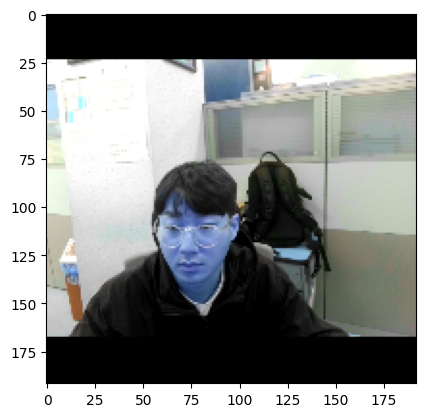

In [37]:
plt.imshow(tf.cast(np.squeeze(img), dtype=tf.int32))

# MoveNet 실전

In [4]:
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pandas as pd

In [5]:
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_lightning_3.tflite")
interpreter.allocate_tensors()

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)



In [6]:
columns = ['nose_X','nose_Y',
    'left_eye_X','left_eye_Y',
    'right_eye_X','right_eye_Y',
    'left_ear_X',"left_ear_Y",
    'right_ear_X','right_ear_Y',
    'left_shoulder_X','left_shoulder_Y',
    'right_shoulder_X','right_shoulder_Y',
    'left_elbow_X','left_elbow_Y',
    'right_elbow_X','right_elbow_Y',
    'left_wrist_X','left_wrist_Y',
    'right_wrist_X','right_wrist_Y']


In [8]:
"""studying 처리"""

keypoint = pd.DataFrame(columns=columns)   # keypoint에 관련 point 좌표 데이터프레임 형식으로 저장
images = os.listdir(path = "imgset/studying")

for idx,image in enumerate(images) : 
    data = []
    path = f"imgset/studying/{idx}.jpg"
    frame = cv2.imread(path)
    
    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    # nose부터 right_wrist까지 x,y 좌표 (총 22개)
    for keypoints_with_score in keypoints_with_scores[0][0][:11]:
        if (keypoints_with_score[2]> 0.1):# 0.1 이하는 point 감지 못 한 것으로 간주
            for ax in range(2):
                data.append(keypoints_with_score[:2][ax]) 
        else :
            for ax in range(2):
                data.append(None)
    keypoint.loc[idx] = data 
        

#     # Rendering (선 연결)
#     draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
#     draw_keypoints(frame, keypoints_with_scores, 0.4)



In [9]:
keypoint.to_csv("keypoint_studying.csv",index=False)
keypoint

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_shoulder_X,right_shoulder_Y,left_elbow_X,left_elbow_Y,right_elbow_X,right_elbow_Y,left_wrist_X,left_wrist_Y,right_wrist_X,right_wrist_Y
0,0.198871,0.781391,0.154452,0.787421,0.133364,0.745978,0.134638,0.694983,0.105760,0.589361,...,0.346544,0.389911,0.773012,0.801967,0.775933,0.541181,0.775754,0.954916,0.758367,0.876276
1,0.292814,0.597660,0.220513,0.656164,0.221686,0.529168,0.218681,0.707080,0.221475,0.424813,...,0.433676,0.263632,0.759121,0.977992,0.775824,0.069817,0.834139,0.832147,0.778759,0.455216
2,0.296077,0.583190,0.245438,0.606826,0.227935,0.531038,0.256828,0.565092,0.235115,0.385950,...,0.459907,0.187493,0.814011,0.814376,0.811357,0.116539,0.846683,0.761080,0.804424,0.498170
3,0.297722,0.412686,0.227859,0.469517,0.251212,0.385285,0.230337,0.609132,0.270355,0.413283,...,0.526543,0.316455,0.812424,0.894230,0.821843,0.153446,0.841328,0.552788,0.883034,0.065642
4,0.246339,0.620141,0.181839,0.665390,0.183311,0.550709,0.202659,0.700963,0.209255,0.443612,...,0.434541,0.287524,NaN,NaN,0.774592,0.103094,NaN,NaN,0.760045,0.473605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.295539,0.660327,0.243943,0.714759,0.223808,0.604666,0.260810,0.752876,0.215038,0.494406,...,0.459618,0.305218,0.781018,0.976072,0.710468,0.052171,NaN,NaN,0.772705,0.325053
61,0.280487,0.449055,0.228123,0.509784,0.238435,0.429840,0.261116,0.641444,0.259175,0.458617,...,0.550856,0.339935,0.816556,0.880480,0.819515,0.157253,NaN,NaN,0.879289,0.057428
62,0.377400,0.374643,0.296023,0.444954,0.306995,0.313517,0.232913,0.567331,0.247953,0.244332,...,0.452100,0.149019,0.767337,0.907490,0.793040,0.033556,0.760937,0.585422,0.860419,0.146682
63,0.482617,0.348061,0.414483,0.424961,0.408102,0.292046,0.299132,0.570823,0.313327,0.226956,...,0.449197,0.135745,0.747827,0.902893,0.730071,0.017296,0.756483,0.609464,0.863095,0.147181


In [64]:
"""playing 처리"""

keypoint = pd.DataFrame(columns=columns)   # keypoint에 관련 point 좌표 데이터프레임 형식으로 저장
images = os.listdir(path = "imgset/playing")

for idx,image in enumerate(images) : 
    data = []
    path = f"imgset/playing/{idx}.jpg"
    frame = cv2.imread(path)
    
    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    
    # nose부터 right_wrist까지 x,y 좌표 (총 22개)
    for keypoints_with_score in keypoints_with_scores[0][0][:11]:
        if (keypoints_with_score[2]> 0.1):# 0.1 이하는 point 감지 못 한 것으로 간주
            for ax in range(2):
                data.append(keypoints_with_score[:2][ax]) 
        else :
            for ax in range(2):
                data.append(None)
    keypoint.loc[idx] = data 
        

#     # Rendering (선 연결)
#     draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
#     draw_keypoints(frame, keypoints_with_scores, 0.4)



In [65]:
keypoint.to_csv("keypoint_playing.csv",index=False)
keypoint

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_shoulder_X,right_shoulder_Y,left_elbow_X,left_elbow_Y,right_elbow_X,right_elbow_Y,left_wrist_X,left_wrist_Y,right_wrist_X,right_wrist_Y
0,0.108453,0.188118,0.079799,0.211656,0.072383,0.147514,0.111603,0.208735,0.100037,0.060476,...,0.247275,0.023572,0.576063,0.216647,0.536024,0.012801,0.805590,0.238872,NaN,NaN
1,0.677465,0.812987,0.645498,0.844939,0.621500,0.806434,0.623116,0.827477,0.562600,0.719110,...,0.651252,0.582602,0.876349,0.847208,0.774261,0.665734,0.850941,0.847568,NaN,NaN
2,0.763106,0.781434,0.734840,0.802297,0.740616,0.758926,0.675707,0.753910,0.686617,0.650908,...,0.714174,0.583097,NaN,NaN,0.802755,0.663431,NaN,NaN,NaN,NaN
3,0.513464,0.876260,0.522626,0.892690,0.502404,0.861657,NaN,NaN,0.309888,0.722896,...,0.386204,0.440988,NaN,NaN,0.722418,0.315704,0.766020,0.807982,0.736633,0.681828
4,0.479964,0.623371,0.433713,0.603628,0.442803,0.598343,0.434241,0.424451,0.485424,0.463016,...,0.713526,0.291862,NaN,NaN,0.733711,0.508586,NaN,NaN,NaN,NaN
5,0.521531,0.589973,0.473475,0.601076,0.485722,0.577934,NaN,NaN,0.493198,0.473815,...,0.757305,0.317107,0.569600,0.470378,0.749674,0.524688,NaN,NaN,0.663315,0.739856
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.650184,0.727414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.583743,0.544039,0.557096,0.569962,0.568590,0.530972,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.662316,0.754069,NaN,NaN
8,0.680351,0.784299,0.650247,0.821366,0.657888,0.783776,NaN,NaN,0.637115,0.743385,...,0.634737,0.697621,NaN,NaN,NaN,NaN,NaN,NaN,0.557193,0.516117
9,0.566159,0.523292,0.552217,0.543799,0.525137,0.508720,0.558807,0.505923,0.552240,0.438331,...,0.755073,0.269769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 정확도 테스트

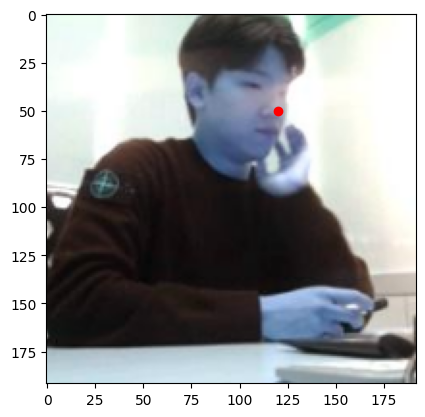

In [13]:
"""studying 테스트"""
tmp_img = cv2.imread("imgset/studying/35.jpg")
tmp_img = tf.image.resize_with_pad(np.expand_dims(tmp_img, axis=0), 192,192)
input_image = tf.cast(tmp_img, dtype=tf.float32)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

plt.imshow(tf.cast(np.squeeze(tmp_img), dtype=tf.int32))

nose = keypoints_with_scores[0][0][0]
axes = np.array(nose[:2]*[192,192]).astype(int)
plt.scatter(axes[1],axes[0],c="r")  # x,y 좌표 반대로 

In [79]:
# 감지 못한 부분 체크 
for keypoints_with_score in keypoints_with_scores[0][0][:11]:
    print(keypoints_with_score )

[0.439139  0.6735388 0.513657 ]
[0.40089315 0.69311416 0.5939969 ]
[0.3844087  0.6501799  0.46211705]
[0.36989725 0.61797    0.35431483]
[0.32032508 0.49944103 0.7258463 ]
[0.5427904  0.51592386 0.35553998]
[0.43769845 0.27783036 0.5972451 ]
[0.75019646 0.68499076 0.19523089]
[0.7846862  0.45961714 0.15853457]
[0.7746748  0.84190595 0.22442952]
[0.76759785 0.73627555 0.10452261]


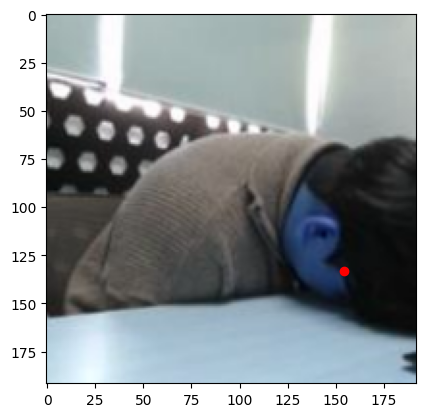

In [14]:
"""playing 테스트"""
tmp_img = cv2.imread("imgset/playing/6.jpg")
tmp_img = tf.image.resize_with_pad(np.expand_dims(tmp_img, axis=0), 192,192)
input_image = tf.cast(tmp_img, dtype=tf.float32)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

plt.imshow(tf.cast(np.squeeze(tmp_img), dtype=tf.int32))

nose = keypoints_with_scores[0][0][0]
axes = np.array(nose[:2]*[192,192]).astype(int)
plt.scatter(axes[1],axes[0],c="r")  # x,y 좌표 반대로 

In [15]:
# 감지 못한 부분 체크 
for keypoints_with_score in keypoints_with_scores[0][0][:11]:
    print(keypoints_with_score )  # x,y,가능성

[0.6959822  0.8054671  0.06824517]
[0.67315257 0.8269838  0.05261664]
[0.67586106 0.80551594 0.07263204]
[0.6257025  0.8068546  0.06532342]
[0.64895976 0.78390306 0.08522375]
[0.5562539  0.7234254  0.06713487]
[0.6501844  0.7274143  0.10931847]
[0.56066084 0.66330546 0.02784053]
[0.71659005 0.5912937  0.02578716]
[0.58858943 0.69286484 0.02931003]
[0.7304702  0.6216849  0.03665641]


In [16]:
keypoints_with_scores[0][0][0]

array([0.6959822 , 0.8054671 , 0.06824517], dtype=float32)

In [17]:
keypoints_with_scores[0][0][0]*192

array([133.62859 , 154.64969 ,  13.103073], dtype=float32)

In [58]:
np.array(nose[:2]*[192,192])

array([20.82296848, 36.11860085])